In [198]:
import torch
import math 
from matplotlib import pyplot as plt 
import numpy as np 
from scipy.stats import multivariate_normal


def gaussian_kernel(sample, mu, epsilon): ## CHECKED
    d = sample.shape[-1]
    return (-((sample - mu)**2).sum(dim = -1)/(2*epsilon**2)).exp()/((2*math.pi*epsilon**2)**(d/2))

#### sample from a gaussian mixture 
def sample_mixture(means, epsilon , M):

    N, d = means.shape
    component_indices = torch.randint(0,N,(M,))

    samples = torch.zeros((M, d))
    cov = epsilon**2 * torch.eye(d)

    for i in range(N):
        count = (component_indices == i).sum().item()
        if count > 0:
            # Sample from N(mus[i], sigmas[i])
            dist = torch.distributions.MultivariateNormal(loc=means[i], covariance_matrix=cov)
            samples_from_i = dist.sample((count,))  
            samples[component_indices == i] = samples_from_i
            

    return samples


# I. Definition of the target $\pi$

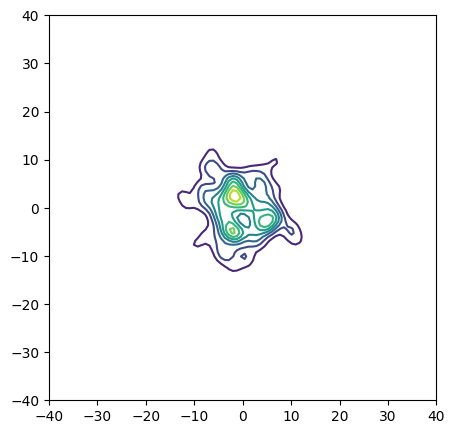

In [189]:


## TARGET
N_target = 100
d = 2
epsilon = math.sqrt(d)

sig = torch.eye(d) * 5**2
mvn_dist = torch.distributions.MultivariateNormal(torch.zeros(d), covariance_matrix=sig)
pi_mean = mvn_dist.sample((N_target,))
pi_cov = torch.eye(d)*epsilon**2
### TARGET

p_dist = [multivariate_normal(mean=mean, cov=pi_cov) for mean in pi_mean]
x = np.linspace(-40, 40, 100)
y = np.linspace(-40, 40, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = np.dstack([p.pdf(pos)/N_target for p in p_dist]).sum(axis = -1)



plt.figure(figsize=(5,5))
plt.contour(X, Y, Z, levels=10, cmap="viridis")



# II. Definiton of $k_\epsilon \star \mu$


$k_\epsilon \star \mu (y) = \frac{1}{n} \sum_{i=1}^n k_{\epsilon^i} (y - x^i)$, with $\epsilon^i \in \mathbb{R}$ and $x^i \in \mathbb{R}^d$.




## II.1 Case $\epsilon$ unique

Here we first suppose that $\epsilon^i$ is unique, i.e. $\forall i = 1, \dots, n, \ \epsilon^i = \epsilon$.


We have $F(\epsilon) = KL(k_\epsilon \star \mu | \pi) $. Thus $\nabla_\epsilon F(\epsilon) = \frac{1}{2} \operatorname{Tr} \mathbb{E}_{k_\epsilon \star \mu} \left[ \nabla_y ^2 \ln \frac{k_\epsilon \star \mu}{\pi} \right]$

Let's first focus on 
\begin{equation}
\operatorname{Tr} \mathbb{E}_{k_\epsilon \star \mu} \left[ \nabla_y ^2 \ln k_\epsilon \star \mu \right] 
\end{equation}

\begin{equation}
\nabla_y^2 \ln (k_\epsilon \star \mu)(y)

= \frac{\sum k_\epsilon (y - x^i) \left[ (y - x^i)(y - x^i)^T - \epsilon^2 I_d \right]}
{\epsilon^2 \sum k_\epsilon (y - x^i)}

- \frac{\sum k_\epsilon (y - x^i)(y - x^i) \left(\sum k_\epsilon (y - x^i) (y - x^i) \right)^T}
{\epsilon^2 \left(\sum k_\epsilon (y - x^i) \right)^2}
\end{equation}
We find out experimentaly that it is related to $-d/\epsilon$.

In [190]:

def hessian_ln_mixture(y, means, epsilons):

    ### it compute hessian of ln of a gaussian mixture with different epsilon. it changes a a bit because if epsilon is the same 
    ### it is still for a simple form of the covariance matrix eps * ID 
    ### for each components we can move the constante in x outside the sum and it simplifies
    ### which we cannot when epsilon is different for each components
    ### out b, d , d 
    ### b is the number of y 

    N, d = means.shape
    
    first_numerator = torch.stack([(gaussian_kernel(y, m, eps)[..., None, None] * (((y-m)[:,:,None]@(y-m)[:,None,:]) - epsilon**2 * torch.eye(d))) for m, eps in zip(means, epsilons)]).sum(dim = 0).mean(dim = 0).diag().sum()

    first_denominator = (torch.stack([gaussian_kernel(y, m, eps) for m, eps in zip(means, epsilons)]).sum(dim = 0) * epsilon**4).mean()
    first_denominator = torch.clamp(first_denominator, 1e-40)

    sum_exp_term = torch.stack([(gaussian_kernel(y, m, eps)[...,None] * (y - m)) for m,eps in zip(means, epsilons)]).sum(dim  = 0)
    second_numerator = (sum_exp_term[:,:, None] @ sum_exp_term[:, None, :]).mean(dim = 0 ).diag().sum()


    second_denominator = ((torch.stack([gaussian_kernel(y, m, eps) for m, eps in zip(means, epsilons)]).sum(dim = 0))**2 * epsilon**4).mean()
    second_denominator = torch.clamp(second_denominator, 1e-40)


    return first_numerator/first_denominator - second_numerator/second_denominator




### II.1.1 Evolution of $(1)$ w.r.t $\epsilon$ for different values of $n$

$\textbf{Setup}$

$n$ is the number of components in the mixture, $n \in \{1, 10, 100\}$ 

$d$ dimension, $d=5$.

$\sqrt \epsilon \in \left[0.01, 5\right]$ 

$x^i$ are drawn from $\mathcal{N}(0, 5^2)$

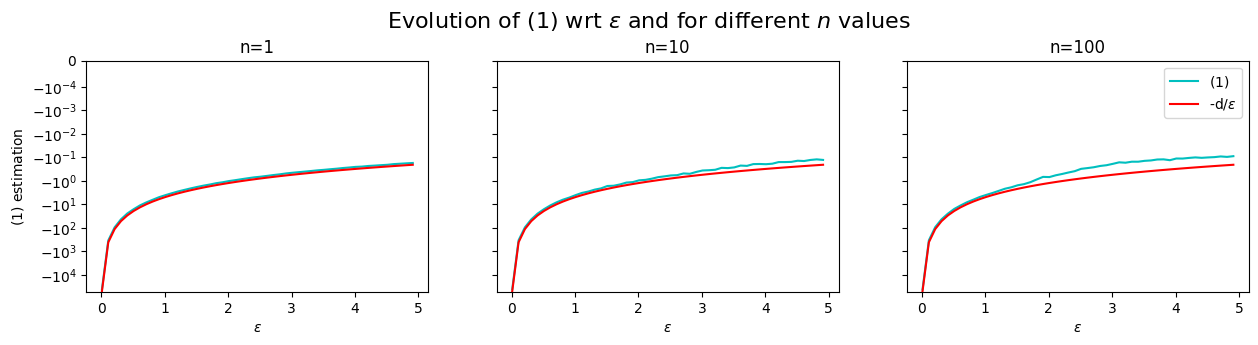

In [191]:

E = torch.arange(0.01, 5, 0.1)
ALL_TH = []
d = 5
TH = []
NS = [1, 10, 100]
fig, axs = plt.subplots(1, len(NS), figsize=(15, 3), sharey=True)
fig.suptitle("Evolution of $(1)$ wrt $\epsilon$ and for different $n$ values", fontsize=16, y=1.05)

for i,n in enumerate(NS):
    TH = []
    for epsilon in E:
        N = n
        X = torch.randn((N,d))*5
        M = 1000

        y = sample_mixture(X, epsilon, M)

        trace_hessian = hessian_ln_mixture(y, X, torch.full((N,1),  fill_value=epsilon))

        TH.append(trace_hessian)


    if i == 0:
                axs[i].set_ylabel("$(1)$ estimation")

    axs[i].plot(E, TH, label = "$(1)$",  color = "c")
    axs[i].plot(E, -d/E**2, label = "-d/$\epsilon$", color = "r")

    axs[i].set_title(f"n={n}")
    axs[i].set_xlabel(r"$\epsilon$")
    axs[i].set_ylim(bottom=None, top=0)
    axs[i].set_yscale('symlog', linthresh=10e-5)
    # axs[i].set_yticks([ -10e9,-10e2,  0, 10e2, 10e9], minor=False)
    ALL_TH.append(TH)

# plt.plot(E, TH, label = "Expectation of the H ln", linewidth = 5, color = "c")
# plt.plot(E, - d / E**2, label = "$-d/\epsilon^2$", color = "r")
# plt.yscale('symlog', linthresh=0.001)
plt.legend()
plt.savefig("plot/epsilon_smoothness/evolution_wrtN.pdf", format="pdf", bbox_inches="tight")


### II.1.2 Evolution of $(1)$ w.r.t $\epsilon$ for different values of $d$

$\textbf{Setup}$

$n$ is the number of components in the mixture, $n = 10$ 

$d$ dimension, $d= \{ 1, 10, 100\}$.

$\sqrt \epsilon \in \left[0.01, 5\right]$ 

$x^i$ are drawn from $\mathcal{N}(0, 5^2)$

WARNING - Problem with gaussian kernel when $d \gg$ is big : 

$Z_\epsilon = \frac{1}{(2\pi \epsilon^2)^{\frac{d}{2}}}$


- when $2\pi \epsilon^2 < 1 $, $Z_\epsilon \rightarrow + \infty$ .
- when $2\pi \epsilon^2 \gg 1 $, $Z_\epsilon \rightarrow 0$ .

In [194]:

def gaussian_kernel(sample, mu, epsilon): ## CHECKED
    d = sample.shape[-1]
    Ze = (2*math.pi*epsilon**2)**(d/2)
    # Ze_clamped = torch.clamp(Ze, 1e-30)
    # Ze_clamped = torch.clamp(Ze, 1e30)
    return (-((sample - mu)**2).sum(dim = -1)/(2*epsilon**2)).exp() / Ze

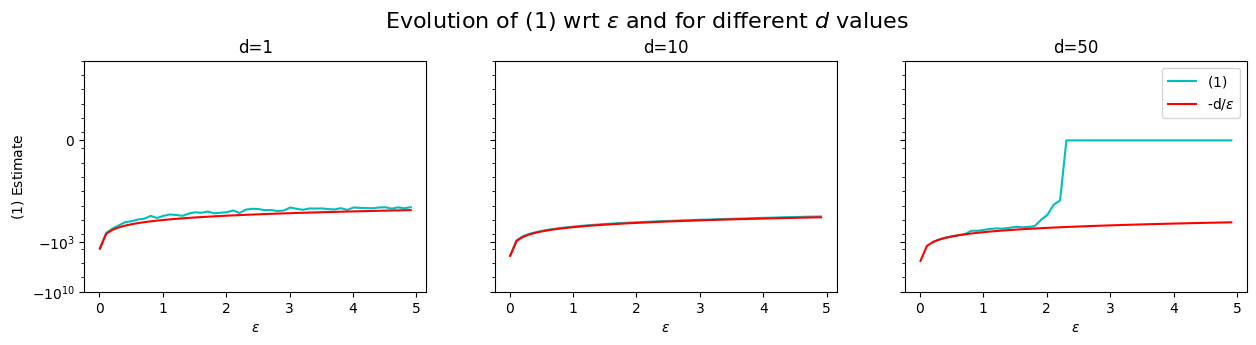

In [197]:

E = torch.arange(0.01, 5, 0.1)
ALL_TH = []
dimensions = [1, 10, 50]
TH = []
fig, axs = plt.subplots(1, len(dimensions), figsize=(15, 3), sharey=True)
fig.suptitle("Evolution of $(1)$ wrt $\epsilon$ and for different $d$ values", fontsize=16, y=1.05)

for i,d in enumerate(dimensions):
    TH = []
    for epsilon in E:
        N = 10
        X = torch.randn((N,d))*5
        M = 1000

        y = sample_mixture(X, epsilon, M)

        trace_hessian = hessian_ln_mixture(y, X, torch.full((N,1),  fill_value=epsilon))

        TH.append(trace_hessian)


    if i == 0:
        axs[i].set_ylabel("$(1)$ Estimate")

    axs[i].plot(E, TH, label = "$(1)$", color = "c")
    axs[i].plot(E, -d/E**2, label = "-d/$\epsilon$", color = "r")

    axs[i].set_title(f"d={d}")
    axs[i].set_xlabel(r"$\epsilon$")
    axs[i].set_ylim(bottom=None, top=1)
    axs[i].set_yscale('symlog', linthresh=1e-10)
    axs[i].set_yticks([ -10e9,-10e2,  0], minor=False)
    ALL_TH.append(TH)

# plt.plot(E, TH, label = "Expectation of the H ln", linewidth = 5, color = "c")
# plt.plot(E, - d / E**2, label = "$-d/\epsilon^2$", color = "r")
# plt.yscale('symlog', linthresh=0.001)
plt.legend()
plt.savefig("plot/epsilon_smoothness/evolution_wrtd.pdf", format="pdf", bbox_inches="tight")


What's happening when $d=50$ and $\epsilon > 2$ ? 

In [160]:
def first_term(y, means, epsilons):
    first_numerator = torch.stack([(gaussian_kernel(y, m, eps)[..., None, None] * (((y-m)[:,:,None]@(y-m)[:,None,:]) - epsilon**2 * torch.eye(d))) for m, eps in zip(means, epsilons)]).sum(dim = 0)

    first_denominator = torch.stack([gaussian_kernel(y, m, eps) for m, eps in zip(means, epsilons)]).sum(dim = 0) * epsilon**4
    return first_numerator, first_denominator

def second_term(y, means, epsilons):

    sum_exp_term = torch.stack([(gaussian_kernel(y, m, eps)[...,None] * (y - m)) for m,eps in zip(means, epsilons)]).sum(dim  = 0)
    second_numerator = (sum_exp_term[:,:, None] @ sum_exp_term[:, None, :])

    second_denominator = (torch.stack([gaussian_kernel(y, m, eps) for m, eps in zip(means, epsilons)]).sum(dim = 0) * epsilon**2)**2

    return second_numerator, second_denominator
